<a href="https://colab.research.google.com/github/iamsauravsharma/insincere-question-classification/blob/bishal/Quora_Insincere_Questions_Classification%20google%20news%200.05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bishalgaire360","key":"69b39489849cd899eaa93339bad30cdb"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c quora-insincere-questions-classification

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
embeddings.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
from zipfile import ZipFile
file_name="train.csv.zip"
#file_name="embeddings.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')



Done


In [6]:
file_name="embeddings.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')


Done


In [8]:
import pandas as pd
df=pd.read_csv('train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import gensim as gn
from tqdm import tqdm_notebook

from keras.layers import LSTM,Bidirectional,TimeDistributed, Embedding,Dense,Input,GlobalMaxPool1D,Flatten,Dropout
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.models import Sequential,Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

Using TensorFlow backend.


In [0]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [11]:
print("Unsincere avg: ", df.target.mean())
print("total: ", df.target.count())

Unsincere avg:  0.06187017751787352
total:  1306122


In [0]:
train, val = train_test_split(df, test_size=0.05,random_state=42)

In [0]:
#train, val = train_test_split(df, test_size=0.1, random_state=42)

n_words = 50000
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(list(train.question_text))

q_train = tokenizer.texts_to_sequences(train.question_text)
q_val = tokenizer.texts_to_sequences(val.question_text)
#q_test = tokenizer.texts_to_sequences(df_test.question_text)

max_len = 100
q_train = pad_sequences(q_train,maxlen=max_len)
q_val = pad_sequences(q_val,maxlen=max_len)
#q_test = pad_sequences(q_test,maxlen=max_len)

y_train = train.target
y_val = val.target

del train,val,df

In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#find the best threshold
def optim_thres(y_val,y_pred):
    score = 0
    thresholds = np.arange(0.1,0.501,0.01)
    for thres in thresholds:
        thres = np.round(thres,2)
        temp_pred = (y_pred > thres).astype(int)
        temp_score = f1_score(y_val,temp_pred)
        print("Thres: {} --------- F1: {}".format(thres,temp_score))
        if temp_score > score:
            score = temp_score
            final_thres = thres
    return final_thres


In [16]:
emb_file = "glove.840B.300d/glove.840B.300d.txt"
#emb_file ="GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
glove_dic = {}
for line in tqdm_notebook(open(emb_file)):
    temp = line.split(" ")
    glove_dic[temp[0]] = np.asarray(temp[1:],dtype='float32')

KeyboardInterrupt: ignored

In [0]:
from gensim.models import KeyedVectors
embed_size=300
emb_file ="GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
embeddings_index = KeyedVectors.load_word2vec_format(emb_file, binary=True)

word_index = tokenizer.word_index
nb_words = min(n_words, len(word_index))
embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= n_words: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector

In [0]:
word_index = tokenizer.word_index
emb_size = glove_dic['.'].shape[0]
emb_matrix = np.zeros((n_words,emb_size))
for w,index in word_index.items():
    if index >= n_words:
        continue
    vec = glove_dic.get(w)
    if vec is not None:
        emb_matrix[index,:] = vec
    

In [18]:
inp = Input(shape=(max_len,))
#x = Embedding(input_dim=n_words,output_dim=emb_size, weights=[emb_matrix])(inp)
x = Embedding(input_dim=n_words,output_dim=embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(100, return_sequences=True))(x)
x = Attention(step_dim=max_len)(x)
x = Dense(36,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp,output=x)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          321600    
_________________________________________________________________
attention_1 (Attention)      (None, 200)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 36)                7236      
_________________________________________________________________
dropout_1 (Dropout)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [19]:
model_name = 'lstm_glove_emb'
checkpoint = ModelCheckpoint(filepath='./{}.hdf5'.format(model_name),
                             monitor='val_f1',mode='max',verbose=1,
                            save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1])
history  = model.fit(q_train,y_train,batch_size=1500,epochs=7,
                     validation_data=(q_val,y_val),verbose=1,callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 1240815 samples, validate on 65307 samples
Epoch 1/7
1240815/1240815 [==============================] - 162s 130us/step - loss: 0.1234 - acc: 0.9521 - f1: 0.5370 - val_loss: 0.1043 - val_acc: 0.9587 - val_f1: 0.5980

Epoch 00001: val_f1 improved from -inf to 0.59796, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1240815/1240815 [==============================] - 163s 131us/step - loss: 0.0991 - acc: 0.9601 - f1: 0.6478 - val_loss: 0.1015 - val_acc: 0.9601 - val_f1: 0.6256

Epoch 00002: val_f1 improved from 0.59796 to 0.62559, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1240815/1240815 [==============================] - 163s 131us/step - loss: 0.0883 - acc: 0.9648 - f1: 0.6980 - val_loss: 0.1050 - val_acc: 0.9594 - val_f1: 0.6364

Epoch 00003: val_f1 improved from 0.62559 to 0.63639, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1240815/1240815 [==============================] - 162s 131us/step - loss: 0.0772 - acc: 0.9694

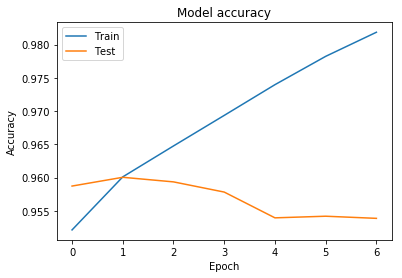

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


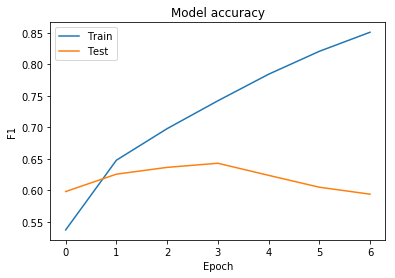

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model accuracy')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [0]:
model_name = 'lstm_glove_emb'
checkpoint = ModelCheckpoint(filepath='./{}.hdf5'.format(model_name),
                             monitor='val_f1',mode='max',verbose=1,
                            save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1])
history  = model.fit(q_train,y_train,batch_size=1500,epochs=7,
                     validation_data=(q_val,y_val),verbose=1,callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 293s 249us/step - loss: 0.1357 - acc: 0.9486 - f1: 0.4724 - val_loss: 0.1080 - val_acc: 0.9568 - val_f1: 0.5677

Epoch 00001: val_f1 improved from -inf to 0.56771, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 302s 257us/step - loss: 0.1047 - acc: 0.9578 - f1: 0.6288 - val_loss: 0.1041 - val_acc: 0.9585 - val_f1: 0.6477

Epoch 00002: val_f1 improved from 0.56771 to 0.64774, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 309s 263us/step - loss: 0.0948 - acc: 0.9618 - f1: 0.6726 - val_loss: 0.1032 - val_acc: 0.9592 - val_f1: 0.6386

Epoch 00003: val_f1 did not improve from 0.64774
Epoch 4/7
1175509/1175509 [==============================] - 292s 248us/step - loss: 0.0846 - acc: 0.9661 - f1: 0.7141 - val_loss: 0.1099 - val_acc

In [0]:
#cnn model


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

Using TensorFlow backend.


In [0]:
def baseline_cnn_model():# Note:do not load this
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(32, 32,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3),input_shape=(14, 14,1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(72, activation='relu'))
    model.add(Dense(46, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
inp = Input(shape=(max_len,))#note: donot load this
x = Embedding(input_dim=n_words,output_dim=emb_size, weights=[emb_matrix])(inp)
x = Bidirectional(CuDNNLSTM(100, return_sequences=True))(x)
x = Attention(step_dim=max_len)(x)
x = Dense(36,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp,output=x)
model.summary()